# Tutorial: NGEM - Neural Graph Error Mitigation

In [1]:
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [7]:
import json
import glob
import os

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

In [8]:
lima = FakeLima()

### (Optional) Generate dataset

In [9]:

N_FILES = 5
N_ENTRIES_PER_FILE = 10

if not os.path.exists("./data/random"):
    os.makedirs("./data/random", exist_ok=True)


for i in range(N_FILES):
    print(f"Generating {i}...")
    generator = exp_value_generator(
        backend=lima,
        n_qubits=5,
        circuit_depth=2,
        pauli_terms=1,
        max_entries=N_ENTRIES_PER_FILE
    )
    entries = []
    for entry in generator:
        entries.append(entry.to_dict())
        
    with open(f"./data/random/{i}.json", "w") as f:
        json.dump(entries, f)


Generating 0...


Exception ignored in: <function tqdm.__del__ at 0x7fd2d190b280>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/blackwater_research/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/anaconda3/envs/blackwater_research/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Generating 1...
Generating 2...
Generating 3...
Generating 4...


### Load data

In [10]:
max_files_to_use = 5
train_size = 4

data_paths = glob.glob("./data/random/**.json")[:max_files_to_use]

BATCH_SIZE = 10

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[:train_size],
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        data_paths[train_size:],
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    # break

DataBatch(x=[389, 22], edge_index=[2, 866], edge_attr=[477, 3], y=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], noisy_0=[10, 1], batch=[389], ptr=[11])
DataBatch(x=[354, 22], edge_index=[2, 770], edge_attr=[416, 3], y=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], noisy_0=[10, 1], batch=[354], ptr=[11])
DataBatch(x=[341, 22], edge_index=[2, 749], edge_attr=[408, 3], y=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], noisy_0=[10, 1], batch=[341], ptr=[11])
DataBatch(x=[346, 22], edge_index=[2, 791], edge_attr=[445, 3], y=[10, 1], observable=[10, 1, 21], circuit_depth=[10, 1], noisy_0=[10, 1], batch=[346], ptr=[11])


### Define model

In [11]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        n_qubits: int,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        
        self.cheb_conv1 = ChebConv(num_node_features, hidden_channels, K=3)
        self.cheb_conv2 = ChebConv(hidden_channels, 1, K=2)

        self.sage_conv1 = SAGEConv(num_node_features, hidden_channels)
        self.sage_conv2 = SAGEConv(hidden_channels, 1)
        
        self.obs_seq = torch.nn.Sequential(
            Linear(n_qubits * 4 + 1, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )
        
        self.body_seq = torch.nn.Sequential(
            Linear(6, hidden_channels),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        # GCN
        graph = self.conv1(nodes, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv2(graph, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv3(graph, edge_index)
        graph = global_mean_pool(graph, batch)
        
        # Cheb
        cheb = self.cheb_conv1(nodes, edge_index).relu()
        cheb = dropout(cheb, training=self.training, p=0.2)
        cheb = self.cheb_conv2(cheb, edge_index)
        cheb = global_mean_pool(cheb, batch)
        
        # Sage
        sage = self.sage_conv1(nodes, edge_index).relu()
        sage = dropout(sage, training=self.training, p=0.2)
        sage = self.sage_conv2(sage, edge_index)
        sage = global_mean_pool(sage, batch)
        
        obs = self.obs_seq(observable)
        obs = torch.mean(obs, dim=1)
        
        merge = torch.cat((
            graph, 
            cheb,
            sage,
            obs,
            circuit_depth,
            exp_value
        ), dim=1)

        return self.body_seq(merge)

### Train

In [12]:
model = ExpValCircuitGraphModel(
    n_qubits=5,
    num_node_features=22,
    hidden_channels=10
)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.5,
                              patience=20,
                              verbose=True,
                              min_lr=0.000001)



/opt/anaconda3/envs/blackwater_research/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch}...")
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, data.y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


### Visualisation

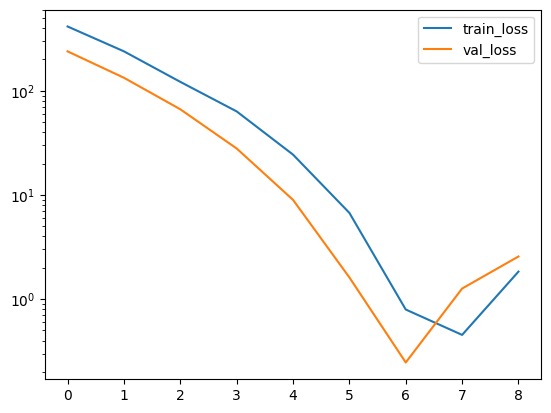

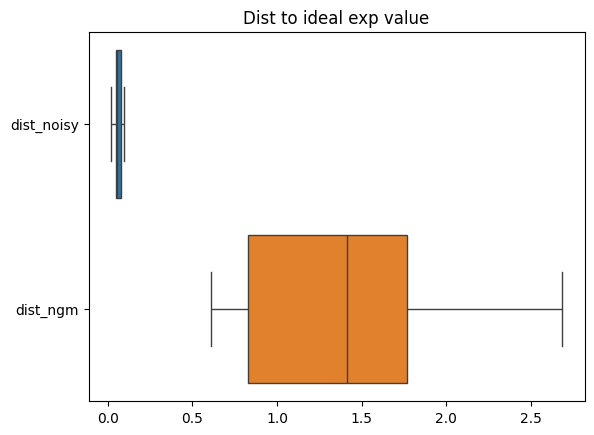

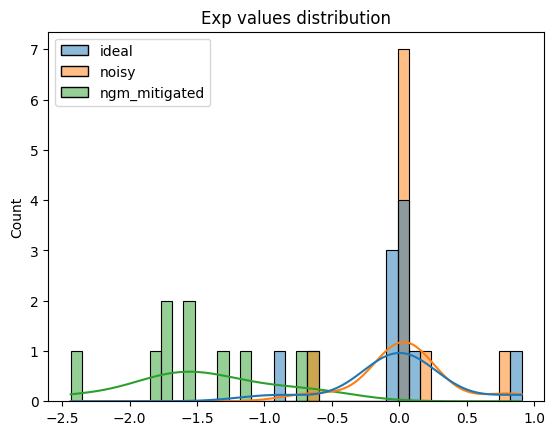

In [15]:

plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

### Estimator

In [16]:
circuit = transpile(random_circuit(5, 2),  lima)
obs = generate_random_pauli_sum_op(5, 1)

In [17]:
NgemEstimator = ngem(Estimator, model=model, backend=lima)

In [18]:
estimator = NgemEstimator()

estimator.run([circuit], [obs]).result()

EstimatorResult(values=array([-1.06495333]), metadata=[{}])